<a href="https://colab.research.google.com/github/ShuaimingJing/CV_final/blob/main/captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
! pip install nltk


In [1]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms
from google.colab import drive
import torch
from tqdm import tqdm
import torch
import torch.nn as nn
import statistics
import torchvision.models as models
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
spacy_eng = spacy.load("en_core_web_sm")


In [3]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset


transform = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor(),]
)

loader, dataset = get_loader(
    "/content/drive/MyDrive/CV_final_project/dataset/Images/",
    "/content/drive/MyDrive/CV_final_project/dataset/captions.txt",
    transform=transform
)

for idx, (imgs, captions) in enumerate(loader):
    print(imgs.shape)
    print(captions.shape)

torch.Size([32, 3, 224, 224])
torch.Size([22, 32])
torch.Size([32, 3, 224, 224])
torch.Size([25, 32])
torch.Size([32, 3, 224, 224])
torch.Size([22, 32])
torch.Size([32, 3, 224, 224])
torch.Size([21, 32])
torch.Size([32, 3, 224, 224])
torch.Size([20, 32])
torch.Size([32, 3, 224, 224])
torch.Size([21, 32])
torch.Size([32, 3, 224, 224])
torch.Size([26, 32])
torch.Size([32, 3, 224, 224])
torch.Size([20, 32])
torch.Size([32, 3, 224, 224])
torch.Size([23, 32])
torch.Size([32, 3, 224, 224])
torch.Size([21, 32])
torch.Size([32, 3, 224, 224])
torch.Size([29, 32])
torch.Size([32, 3, 224, 224])
torch.Size([20, 32])
torch.Size([32, 3, 224, 224])
torch.Size([21, 32])
torch.Size([32, 3, 224, 224])
torch.Size([19, 32])
torch.Size([32, 3, 224, 224])
torch.Size([22, 32])
torch.Size([32, 3, 224, 224])
torch.Size([28, 32])
torch.Size([32, 3, 224, 224])
torch.Size([26, 32])
torch.Size([32, 3, 224, 224])
torch.Size([21, 32])
torch.Size([32, 3, 224, 224])
torch.Size([23, 32])
torch.Size([32, 3, 224, 224])
t

In [19]:
print(len(dataset.vocab))

2994


In [4]:
import torch
import torch.nn as nn
import statistics
import torchvision.models as models


class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    # def forward(self, images):
    #     features = self.inception(images)
    #     return self.dropout(self.relu(features))
    def forward(self, images):
        # Extract only the logits from InceptionOutputs
        features = self.inception(images)
        if isinstance(features, models.inception.InceptionOutputs):  # Check for InceptionOutputs
            features = features.logits  # Use only the logits
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [5]:
def save_checkpoint(state, epoch, directory="/content/drive/MyDrive/CV_final_project/", folder_name="checkpoints"):
    # Create the subfolder path
    subfolder = os.path.join(directory, folder_name)

    # Ensure the subfolder exists
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)
        print(f"=> Created directory: {subfolder}")

    # Format the filename with the epoch number
    filename = os.path.join(subfolder, f"checkpoint_epoch_{epoch}.pth.tar")

    print(f"=> Saving checkpoint for epoch {epoch} to {filename}")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

# Embeded_size & hidden_size: 256

In [29]:

transform = transforms.Compose(
    [
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, dataset = get_loader(
    root_folder="/content/drive/MyDrive/CV_final_project/dataset/Images/",
    annotation_file="/content/drive/MyDrive/CV_final_project/dataset/captions.txt",
    transform=transform,
    num_workers=8,
)

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True
train_CNN = False

# Hyperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 100

# for tensorboard
writer = SummaryWriter("runs/flickr")
step = 0

# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Only finetune the CNN
for name, param in model.encoderCNN.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = train_CNN

if load_model:
    step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

model.train()

epoch_losses = []
for epoch in range(num_epochs):
    # Uncomment the line below to see a couple of test cases
    # print_examples(model, device, dataset)

    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "step": step,
        }
        save_checkpoint(checkpoint, epoch)
    epoch_loss = 0
    for idx, (imgs, captions) in tqdm(
        enumerate(train_loader), total=len(train_loader), leave=False
    ):
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:-1])
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )

        writer.add_scalar("Training loss", loss.item(), global_step=step)
        step += 1

        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()
        epoch_loss += loss.item()

    epoch_losses.append(epoch_loss / len(train_loader))



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=> Saving checkpoint for epoch 0 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_0.pth.tar


=> Saving checkpoint for epoch 1 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_1.pth.tar


=> Saving checkpoint for epoch 2 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_2.pth.tar


=> Saving checkpoint for epoch 3 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_3.pth.tar


=> Saving checkpoint for epoch 4 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_4.pth.tar


=> Saving checkpoint for epoch 5 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_5.pth.tar


=> Saving checkpoint for epoch 6 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_6.pth.tar


=> Saving checkpoint for epoch 7 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_7.pth.tar


=> Saving checkpoint for epoch 8 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_8.pth.tar


=> Saving checkpoint for epoch 9 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_9.pth.tar


=> Saving checkpoint for epoch 10 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_10.pth.tar


=> Saving checkpoint for epoch 11 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_11.pth.tar


=> Saving checkpoint for epoch 12 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_12.pth.tar


=> Saving checkpoint for epoch 13 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_13.pth.tar


=> Saving checkpoint for epoch 14 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_14.pth.tar


=> Saving checkpoint for epoch 15 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_15.pth.tar


=> Saving checkpoint for epoch 16 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_16.pth.tar


=> Saving checkpoint for epoch 17 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_17.pth.tar


=> Saving checkpoint for epoch 18 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_18.pth.tar


=> Saving checkpoint for epoch 19 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_19.pth.tar


=> Saving checkpoint for epoch 20 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_20.pth.tar


=> Saving checkpoint for epoch 21 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_21.pth.tar


=> Saving checkpoint for epoch 22 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_22.pth.tar


=> Saving checkpoint for epoch 23 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_23.pth.tar


=> Saving checkpoint for epoch 24 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_24.pth.tar


=> Saving checkpoint for epoch 25 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_25.pth.tar


=> Saving checkpoint for epoch 26 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_26.pth.tar


=> Saving checkpoint for epoch 27 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_27.pth.tar


=> Saving checkpoint for epoch 28 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_28.pth.tar


=> Saving checkpoint for epoch 29 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_29.pth.tar


=> Saving checkpoint for epoch 30 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_30.pth.tar


=> Saving checkpoint for epoch 31 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_31.pth.tar


=> Saving checkpoint for epoch 32 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_32.pth.tar


=> Saving checkpoint for epoch 33 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_33.pth.tar


=> Saving checkpoint for epoch 34 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_34.pth.tar


=> Saving checkpoint for epoch 35 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_35.pth.tar


=> Saving checkpoint for epoch 36 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_36.pth.tar


=> Saving checkpoint for epoch 37 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_37.pth.tar


=> Saving checkpoint for epoch 38 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_38.pth.tar


=> Saving checkpoint for epoch 39 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_39.pth.tar


=> Saving checkpoint for epoch 40 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_40.pth.tar


=> Saving checkpoint for epoch 41 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_41.pth.tar


=> Saving checkpoint for epoch 42 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_42.pth.tar


=> Saving checkpoint for epoch 43 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_43.pth.tar


=> Saving checkpoint for epoch 44 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_44.pth.tar


=> Saving checkpoint for epoch 45 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_45.pth.tar


=> Saving checkpoint for epoch 46 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_46.pth.tar


=> Saving checkpoint for epoch 47 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_47.pth.tar


=> Saving checkpoint for epoch 48 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_48.pth.tar


=> Saving checkpoint for epoch 49 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_49.pth.tar


=> Saving checkpoint for epoch 50 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_50.pth.tar


=> Saving checkpoint for epoch 51 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_51.pth.tar


=> Saving checkpoint for epoch 52 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_52.pth.tar


=> Saving checkpoint for epoch 53 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_53.pth.tar


=> Saving checkpoint for epoch 54 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_54.pth.tar


=> Saving checkpoint for epoch 55 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_55.pth.tar


=> Saving checkpoint for epoch 56 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_56.pth.tar


=> Saving checkpoint for epoch 57 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_57.pth.tar


=> Saving checkpoint for epoch 58 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_58.pth.tar


=> Saving checkpoint for epoch 59 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_59.pth.tar


=> Saving checkpoint for epoch 60 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_60.pth.tar


=> Saving checkpoint for epoch 61 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_61.pth.tar


=> Saving checkpoint for epoch 62 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_62.pth.tar


=> Saving checkpoint for epoch 63 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_63.pth.tar


=> Saving checkpoint for epoch 64 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_64.pth.tar


=> Saving checkpoint for epoch 65 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_65.pth.tar


=> Saving checkpoint for epoch 66 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_66.pth.tar


=> Saving checkpoint for epoch 67 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_67.pth.tar


=> Saving checkpoint for epoch 68 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_68.pth.tar


=> Saving checkpoint for epoch 69 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_69.pth.tar


=> Saving checkpoint for epoch 70 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_70.pth.tar


=> Saving checkpoint for epoch 71 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_71.pth.tar


=> Saving checkpoint for epoch 72 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_72.pth.tar


=> Saving checkpoint for epoch 73 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_73.pth.tar


=> Saving checkpoint for epoch 74 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_74.pth.tar


=> Saving checkpoint for epoch 75 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_75.pth.tar


=> Saving checkpoint for epoch 76 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_76.pth.tar


=> Saving checkpoint for epoch 77 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_77.pth.tar


=> Saving checkpoint for epoch 78 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_78.pth.tar


=> Saving checkpoint for epoch 79 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_79.pth.tar


=> Saving checkpoint for epoch 80 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_80.pth.tar


=> Saving checkpoint for epoch 81 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_81.pth.tar


=> Saving checkpoint for epoch 82 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_82.pth.tar


=> Saving checkpoint for epoch 83 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_83.pth.tar


=> Saving checkpoint for epoch 84 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_84.pth.tar


=> Saving checkpoint for epoch 85 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_85.pth.tar


=> Saving checkpoint for epoch 86 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_86.pth.tar


=> Saving checkpoint for epoch 87 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_87.pth.tar


=> Saving checkpoint for epoch 88 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_88.pth.tar


=> Saving checkpoint for epoch 89 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_89.pth.tar


=> Saving checkpoint for epoch 90 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_90.pth.tar


=> Saving checkpoint for epoch 91 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_91.pth.tar


=> Saving checkpoint for epoch 92 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_92.pth.tar


=> Saving checkpoint for epoch 93 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_93.pth.tar


=> Saving checkpoint for epoch 94 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_94.pth.tar


=> Saving checkpoint for epoch 95 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_95.pth.tar


=> Saving checkpoint for epoch 96 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_96.pth.tar


=> Saving checkpoint for epoch 97 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_97.pth.tar


=> Saving checkpoint for epoch 98 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_98.pth.tar


=> Saving checkpoint for epoch 99 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_99.pth.tar


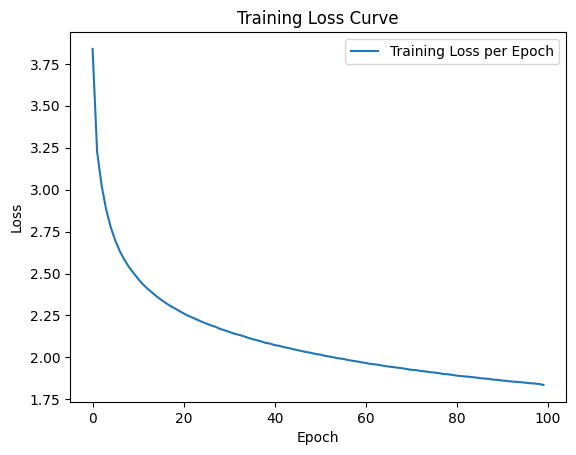

In [30]:
plt.plot(epoch_losses, label="Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

=> Loading checkpoint from /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_99.pth.tar


<ipython-input-26-b4fd557d233e>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


=> Loaded checkpoint and set model to evaluation mode
Generated Caption: ['<SOS>', 'a', 'brown', 'dog', 'is', 'running', 'through', 'a', 'grassy', 'area', '.', '<EOS>']


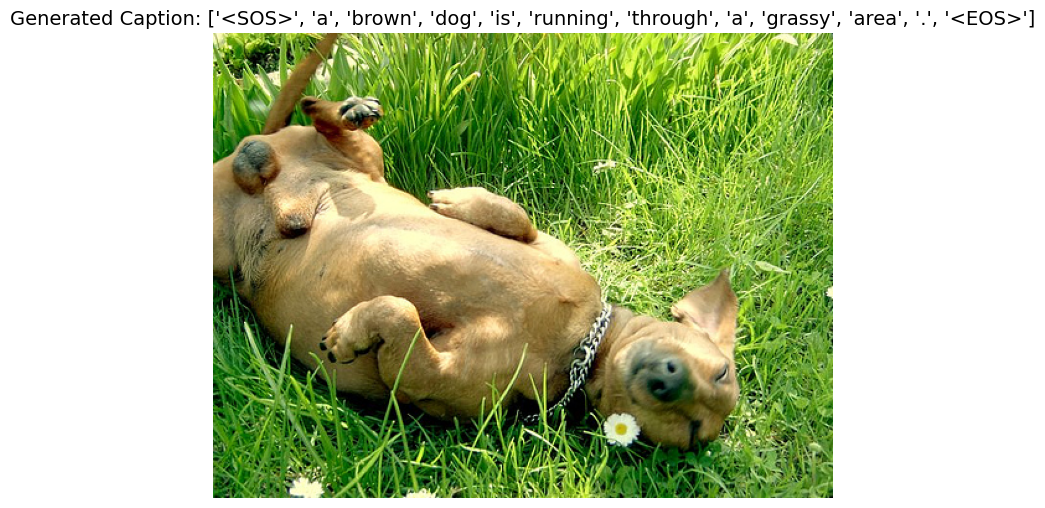

In [26]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load your model definition (ensure it matches the trained model)
model = CNNtoRNN(embed_size=256, hidden_size=256, vocab_size=len(dataset.vocab), num_layers=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define a function to load the checkpoint
def load_checkpoint_for_inference(checkpoint_path, model):
    print(f"=> Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()  # Set the model to evaluation mode
    print("=> Loaded checkpoint and set model to evaluation mode")

# Load the checkpoint
checkpoint_path = "/content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_99.pth.tar"
load_checkpoint_for_inference(checkpoint_path, model)

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((356, 356)),
    transforms.RandomCrop((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load and preprocess the image
image_path = "/content/drive/MyDrive/CV_final_project/test_sets/229862312_1a0ba19dab.jpg"  # Path to your input image
img = Image.open(image_path).convert("RGB")
original_image = img.copy()  # Save the original image for display
img = transform(img).unsqueeze(0)  # Add batch dimension
img = img.to(device)

# Perform inference
with torch.no_grad():
    output = model.caption_image(img, dataset.vocab)  # Use the caption generation function from your model

# Decode the output and print the caption
print("Generated Caption:", output)

# Show the uploaded image alongside the generated caption
plt.figure(figsize=(8, 8))
plt.imshow(original_image)  # Display the original image
plt.axis("off")  # Hide the axis
plt.title(f"Generated Caption: {output}", fontsize=14)
plt.show()


Generated Caption: ['<SOS>', 'a', 'man', 'and', 'a', 'woman', 'are', 'sitting', 'on', 'a', 'bench', '.', '<EOS>']


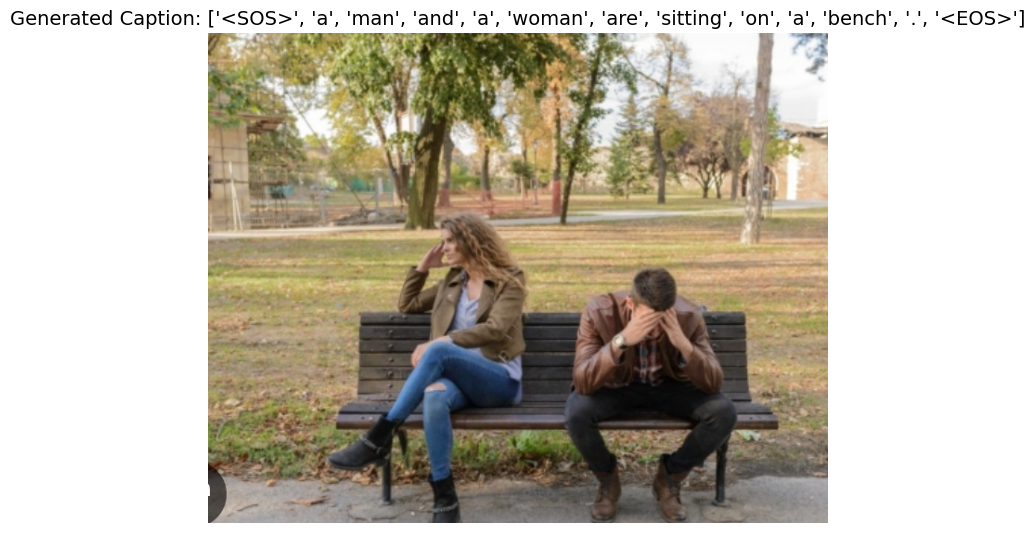

In [25]:
# Load and preprocess the image
image_path = "/content/drive/MyDrive/CV_final_project/test_sets/Screenshot 2024-12-06 at 7.06.31 PM.png"  # Path to your input image
img = Image.open(image_path).convert("RGB")
original_image = img.copy()  # Save the original image for display
img = transform(img).unsqueeze(0)  # Add batch dimension
img = img.to(device)

# Perform inference
with torch.no_grad():
    output = model.caption_image(img, dataset.vocab)  # Use the caption generation function from your model

# Decode the output and print the caption
print("Generated Caption:", output)

# Show the uploaded image alongside the generated caption
plt.figure(figsize=(8, 8))
plt.imshow(original_image)  # Display the original image
plt.axis("off")  # Hide the axis
plt.title(f"Generated Caption: {output}", fontsize=14)
plt.show()

Generated Caption: ['<SOS>', 'a', 'man', 'and', 'a', 'woman', 'are', 'sitting', 'at', 'a', 'table', 'in', 'a', 'restaurant', '.', '<EOS>']


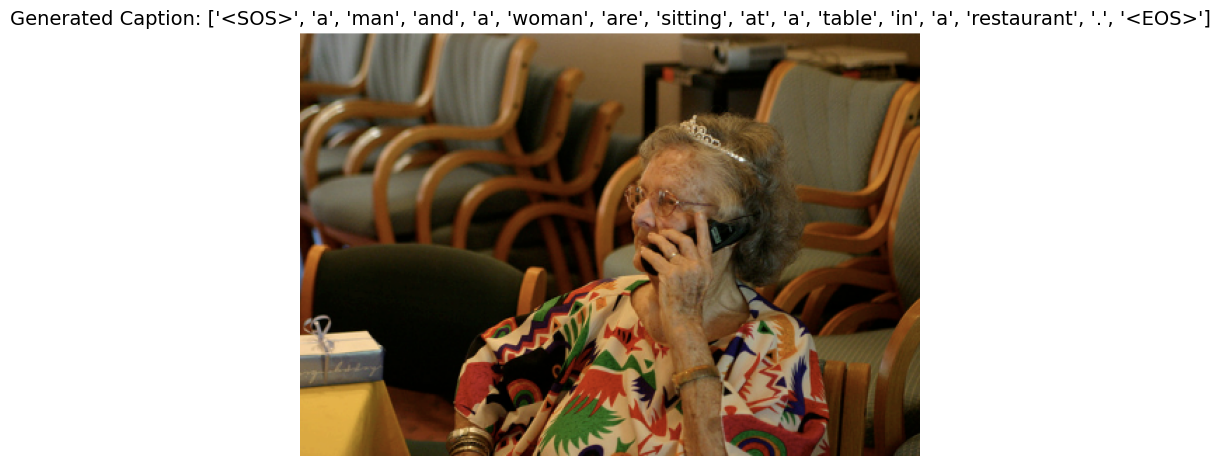

In [30]:
# Load and preprocess the image
image_path = "/content/drive/MyDrive/CV_final_project/test_sets/Screenshot 2024-12-07 at 8.09.16 PM.png"  # Path to your input image
img = Image.open(image_path).convert("RGB")
original_image = img.copy()  # Save the original image for display
img = transform(img).unsqueeze(0)  # Add batch dimension
img = img.to(device)

# Perform inference
with torch.no_grad():
    output = model.caption_image(img, dataset.vocab)  # Use the caption generation function from your model

# Decode the output and print the caption
print("Generated Caption:", output)

# Show the uploaded image alongside the generated caption
plt.figure(figsize=(8, 8))
plt.imshow(original_image)  # Display the original image
plt.axis("off")  # Hide the axis
plt.title(f"Generated Caption: {output}", fontsize=14)
plt.show()

Generated Caption: ['<SOS>', 'a', 'dog', 'runs', 'through', 'the', 'grass', '.', '<EOS>']


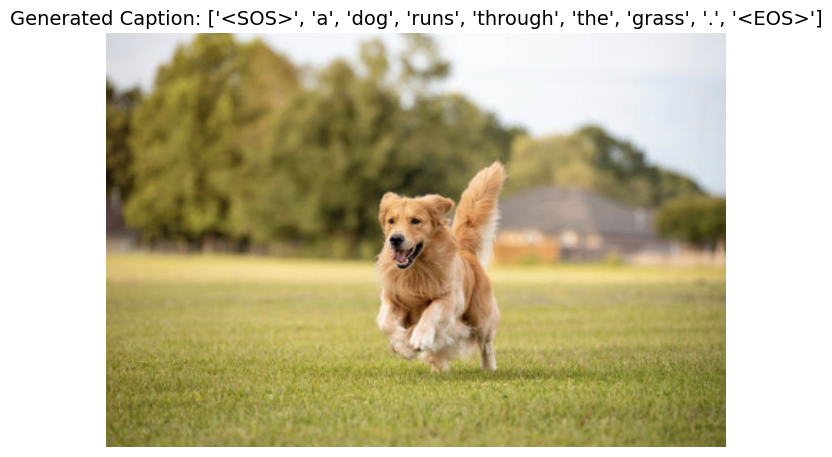

In [31]:
# Load and preprocess the image
image_path = "/content/drive/MyDrive/CV_final_project/test_sets/Screenshot 2024-12-07 at 8.11.25 PM.png"  # Path to your input image
img = Image.open(image_path).convert("RGB")
original_image = img.copy()  # Save the original image for display
img = transform(img).unsqueeze(0)  # Add batch dimension
img = img.to(device)

# Perform inference
with torch.no_grad():
    output = model.caption_image(img, dataset.vocab)  # Use the caption generation function from your model

# Decode the output and print the caption
print("Generated Caption:", output)

# Show the uploaded image alongside the generated caption
plt.figure(figsize=(8, 8))
plt.imshow(original_image)  # Display the original image
plt.axis("off")  # Hide the axis
plt.title(f"Generated Caption: {output}", fontsize=14)
plt.show()

Generated Caption: ['<SOS>', 'a', 'man', 'in', 'a', 'white', 'shirt', 'and', 'jeans', 'is', 'standing', 'in', 'front', 'of', 'a', '<UNK>', '.', '<EOS>']


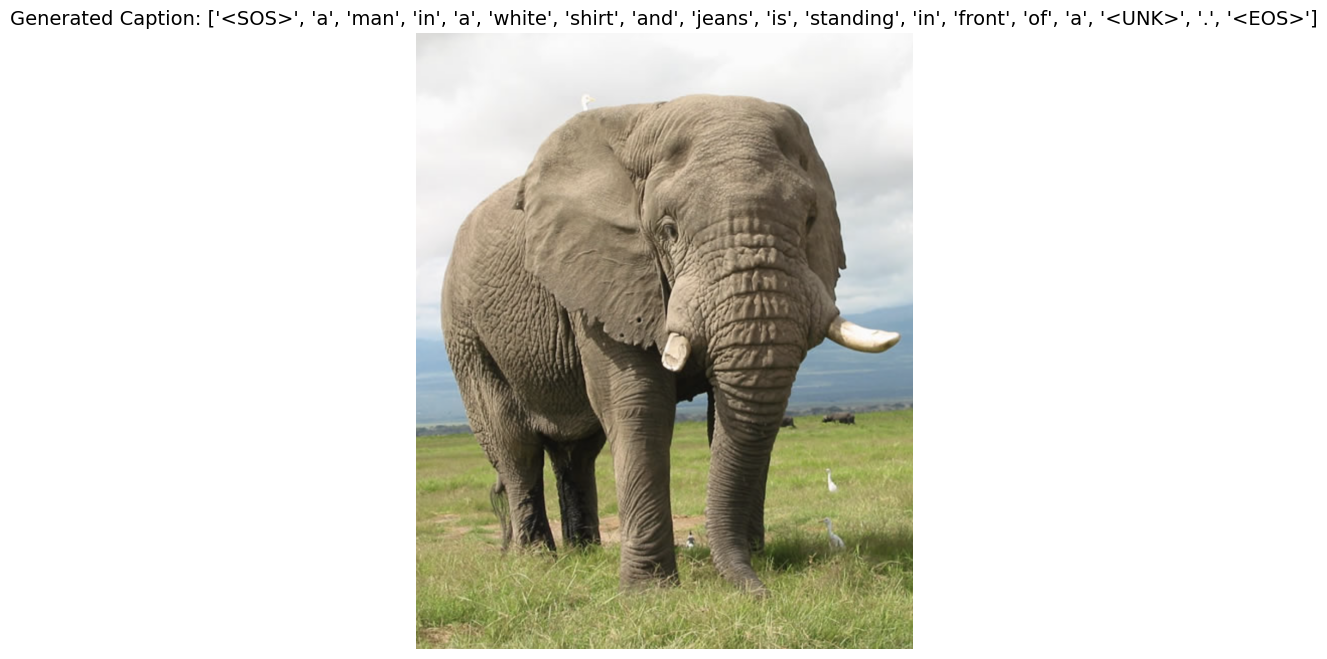

In [32]:
# Load and preprocess the image
image_path = "/content/drive/MyDrive/CV_final_project/test_sets/elephant.png"  # Path to your input image
img = Image.open(image_path).convert("RGB")
original_image = img.copy()  # Save the original image for display
img = transform(img).unsqueeze(0)  # Add batch dimension
img = img.to(device)

# Perform inference
with torch.no_grad():
    output = model.caption_image(img, dataset.vocab)  # Use the caption generation function from your model

# Decode the output and print the caption
print("Generated Caption:", output)

# Show the uploaded image alongside the generated caption
plt.figure(figsize=(8, 8))
plt.imshow(original_image)  # Display the original image
plt.axis("off")  # Hide the axis
plt.title(f"Generated Caption: {output}", fontsize=14)
plt.show()

# Embeded_size & hidden_size: 512

In [6]:

transform = transforms.Compose(
    [
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, dataset = get_loader(
    root_folder="/content/drive/MyDrive/CV_final_project/dataset/Images/",
    annotation_file="/content/drive/MyDrive/CV_final_project/dataset/captions.txt",
    transform=transform,
    num_workers=8,
)

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True
train_CNN = False

# Hyperparameters
embed_size = 512
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 100

# for tensorboard
writer = SummaryWriter("runs/flickr")
step = 0

# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Only finetune the CNN
for name, param in model.encoderCNN.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = train_CNN

if load_model:
    step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

model.train()

epoch_losses = []
for epoch in range(num_epochs):
    # Uncomment the line below to see a couple of test cases
    # print_examples(model, device, dataset)

    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "step": step,
        }
        save_checkpoint(checkpoint, epoch)
    epoch_loss = 0
    for idx, (imgs, captions) in tqdm(
        enumerate(train_loader), total=len(train_loader), leave=False
    ):
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:-1])
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )

        writer.add_scalar("Training loss", loss.item(), global_step=step)
        step += 1

        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()
        epoch_loss += loss.item()

    epoch_losses.append(epoch_loss / len(train_loader))



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 215MB/s]


=> Saving checkpoint for epoch 0 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_0.pth.tar


=> Saving checkpoint for epoch 1 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_1.pth.tar


=> Saving checkpoint for epoch 2 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_2.pth.tar


=> Saving checkpoint for epoch 3 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_3.pth.tar


=> Saving checkpoint for epoch 4 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_4.pth.tar


=> Saving checkpoint for epoch 5 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_5.pth.tar


=> Saving checkpoint for epoch 6 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_6.pth.tar


=> Saving checkpoint for epoch 7 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_7.pth.tar


=> Saving checkpoint for epoch 8 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_8.pth.tar


=> Saving checkpoint for epoch 9 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_9.pth.tar


=> Saving checkpoint for epoch 10 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_10.pth.tar


=> Saving checkpoint for epoch 11 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_11.pth.tar


=> Saving checkpoint for epoch 12 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_12.pth.tar


=> Saving checkpoint for epoch 13 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_13.pth.tar


=> Saving checkpoint for epoch 14 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_14.pth.tar


=> Saving checkpoint for epoch 15 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_15.pth.tar


=> Saving checkpoint for epoch 16 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_16.pth.tar


=> Saving checkpoint for epoch 17 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_17.pth.tar


=> Saving checkpoint for epoch 18 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_18.pth.tar


=> Saving checkpoint for epoch 19 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_19.pth.tar


=> Saving checkpoint for epoch 20 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_20.pth.tar


=> Saving checkpoint for epoch 21 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_21.pth.tar


=> Saving checkpoint for epoch 22 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_22.pth.tar


=> Saving checkpoint for epoch 23 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_23.pth.tar


=> Saving checkpoint for epoch 24 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_24.pth.tar


=> Saving checkpoint for epoch 25 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_25.pth.tar


=> Saving checkpoint for epoch 26 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_26.pth.tar


=> Saving checkpoint for epoch 27 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_27.pth.tar


=> Saving checkpoint for epoch 28 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_28.pth.tar


=> Saving checkpoint for epoch 29 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_29.pth.tar


=> Saving checkpoint for epoch 30 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_30.pth.tar


=> Saving checkpoint for epoch 31 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_31.pth.tar


=> Saving checkpoint for epoch 32 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_32.pth.tar


=> Saving checkpoint for epoch 33 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_33.pth.tar


=> Saving checkpoint for epoch 34 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_34.pth.tar


=> Saving checkpoint for epoch 35 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_35.pth.tar


=> Saving checkpoint for epoch 36 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_36.pth.tar


=> Saving checkpoint for epoch 37 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_37.pth.tar


=> Saving checkpoint for epoch 38 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_38.pth.tar


=> Saving checkpoint for epoch 39 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_39.pth.tar


=> Saving checkpoint for epoch 40 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_40.pth.tar


=> Saving checkpoint for epoch 41 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_41.pth.tar


=> Saving checkpoint for epoch 42 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_42.pth.tar


=> Saving checkpoint for epoch 43 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_43.pth.tar


=> Saving checkpoint for epoch 44 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_44.pth.tar


=> Saving checkpoint for epoch 45 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_45.pth.tar


=> Saving checkpoint for epoch 46 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_46.pth.tar


=> Saving checkpoint for epoch 47 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_47.pth.tar


=> Saving checkpoint for epoch 48 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_48.pth.tar


=> Saving checkpoint for epoch 49 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_49.pth.tar


=> Saving checkpoint for epoch 50 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_50.pth.tar


=> Saving checkpoint for epoch 51 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_51.pth.tar


=> Saving checkpoint for epoch 52 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_52.pth.tar


=> Saving checkpoint for epoch 53 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_53.pth.tar


=> Saving checkpoint for epoch 54 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_54.pth.tar


=> Saving checkpoint for epoch 55 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_55.pth.tar


=> Saving checkpoint for epoch 56 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_56.pth.tar


=> Saving checkpoint for epoch 57 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_57.pth.tar


=> Saving checkpoint for epoch 58 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_58.pth.tar


=> Saving checkpoint for epoch 59 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_59.pth.tar


=> Saving checkpoint for epoch 60 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_60.pth.tar


=> Saving checkpoint for epoch 61 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_61.pth.tar


=> Saving checkpoint for epoch 62 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_62.pth.tar


=> Saving checkpoint for epoch 63 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_63.pth.tar


=> Saving checkpoint for epoch 64 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_64.pth.tar


=> Saving checkpoint for epoch 65 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_65.pth.tar


=> Saving checkpoint for epoch 66 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_66.pth.tar


=> Saving checkpoint for epoch 67 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_67.pth.tar


=> Saving checkpoint for epoch 68 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_68.pth.tar


=> Saving checkpoint for epoch 69 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_69.pth.tar


=> Saving checkpoint for epoch 70 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_70.pth.tar


=> Saving checkpoint for epoch 71 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_71.pth.tar


=> Saving checkpoint for epoch 72 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_72.pth.tar


=> Saving checkpoint for epoch 73 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_73.pth.tar


=> Saving checkpoint for epoch 74 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_74.pth.tar


=> Saving checkpoint for epoch 75 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_75.pth.tar


=> Saving checkpoint for epoch 76 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_76.pth.tar


=> Saving checkpoint for epoch 77 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_77.pth.tar


=> Saving checkpoint for epoch 78 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_78.pth.tar


=> Saving checkpoint for epoch 79 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_79.pth.tar


=> Saving checkpoint for epoch 80 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_80.pth.tar


=> Saving checkpoint for epoch 81 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_81.pth.tar


=> Saving checkpoint for epoch 82 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_82.pth.tar


=> Saving checkpoint for epoch 83 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_83.pth.tar


=> Saving checkpoint for epoch 84 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_84.pth.tar


=> Saving checkpoint for epoch 85 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_85.pth.tar


=> Saving checkpoint for epoch 86 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_86.pth.tar


=> Saving checkpoint for epoch 87 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_87.pth.tar


=> Saving checkpoint for epoch 88 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_88.pth.tar


=> Saving checkpoint for epoch 89 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_89.pth.tar


=> Saving checkpoint for epoch 90 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_90.pth.tar


=> Saving checkpoint for epoch 91 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_91.pth.tar


=> Saving checkpoint for epoch 92 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_92.pth.tar


=> Saving checkpoint for epoch 93 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_93.pth.tar


=> Saving checkpoint for epoch 94 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_94.pth.tar


=> Saving checkpoint for epoch 95 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_95.pth.tar


=> Saving checkpoint for epoch 96 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_96.pth.tar


=> Saving checkpoint for epoch 97 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_97.pth.tar


=> Saving checkpoint for epoch 98 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_98.pth.tar


=> Saving checkpoint for epoch 99 to /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_99.pth.tar


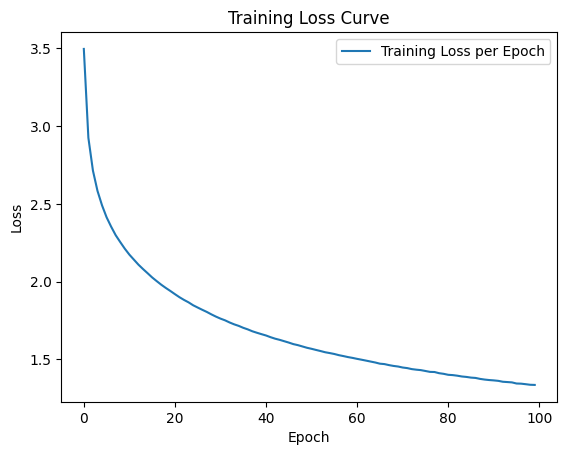

In [7]:
plt.plot(epoch_losses, label="Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

=> Loading checkpoint from /content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_99.pth.tar


<ipython-input-13-372024137060>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


=> Loaded checkpoint and set model to evaluation mode
Generated Caption: ['<SOS>', 'a', 'brown', 'dog', 'is', 'running', 'through', 'a', 'grassy', 'field', '.', '<EOS>']


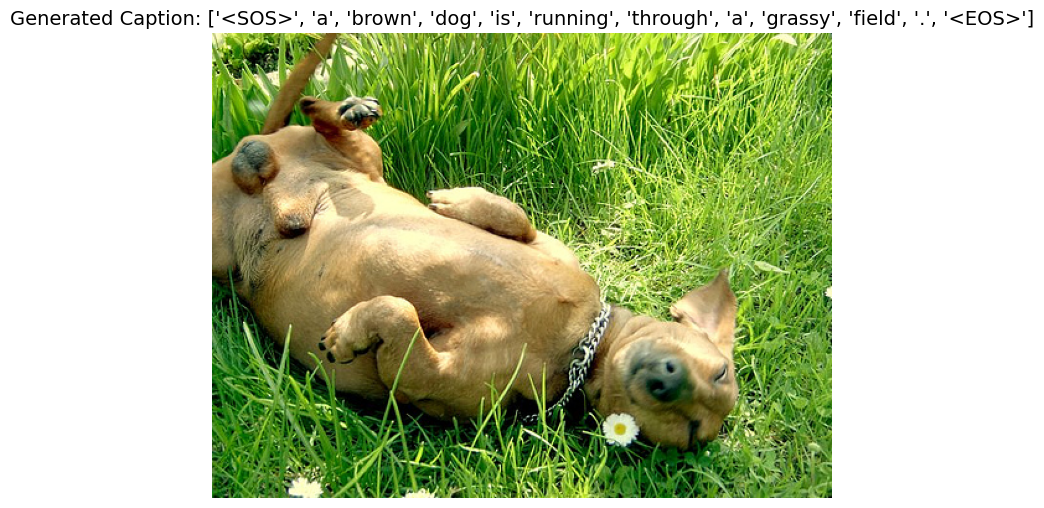

In [13]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load your model definition (ensure it matches the trained model)
model = CNNtoRNN(embed_size=512, hidden_size=512, vocab_size=len(dataset.vocab), num_layers=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define a function to load the checkpoint
def load_checkpoint_for_inference(checkpoint_path, model):
    print(f"=> Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()  # Set the model to evaluation mode
    print("=> Loaded checkpoint and set model to evaluation mode")

# Load the checkpoint
checkpoint_path = "/content/drive/MyDrive/CV_final_project/checkpoints/checkpoint_epoch_99.pth.tar"
load_checkpoint_for_inference(checkpoint_path, model)

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((356, 356)),
    transforms.RandomCrop((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load and preprocess the image
image_path = "/content/drive/MyDrive/CV_final_project/test_sets/229862312_1a0ba19dab.jpg"  # Path to your input image
img = Image.open(image_path).convert("RGB")
original_image = img.copy()  # Save the original image for display
img = transform(img).unsqueeze(0)  # Add batch dimension
img = img.to(device)

# Perform inference
with torch.no_grad():
    output = model.caption_image(img, dataset.vocab)  # Use the caption generation function from your model

# Decode the output and print the caption
print("Generated Caption:", output)

# Show the uploaded image alongside the generated caption
plt.figure(figsize=(8, 8))
plt.imshow(original_image)  # Display the original image
plt.axis("off")  # Hide the axis
plt.title(f"Generated Caption: {output}", fontsize=14)
plt.show()


Generated Caption: ['<SOS>', 'a', 'man', 'and', 'a', 'woman', 'are', 'sitting', 'on', 'a', 'bench', 'in', 'a', 'park', '.', '<EOS>']


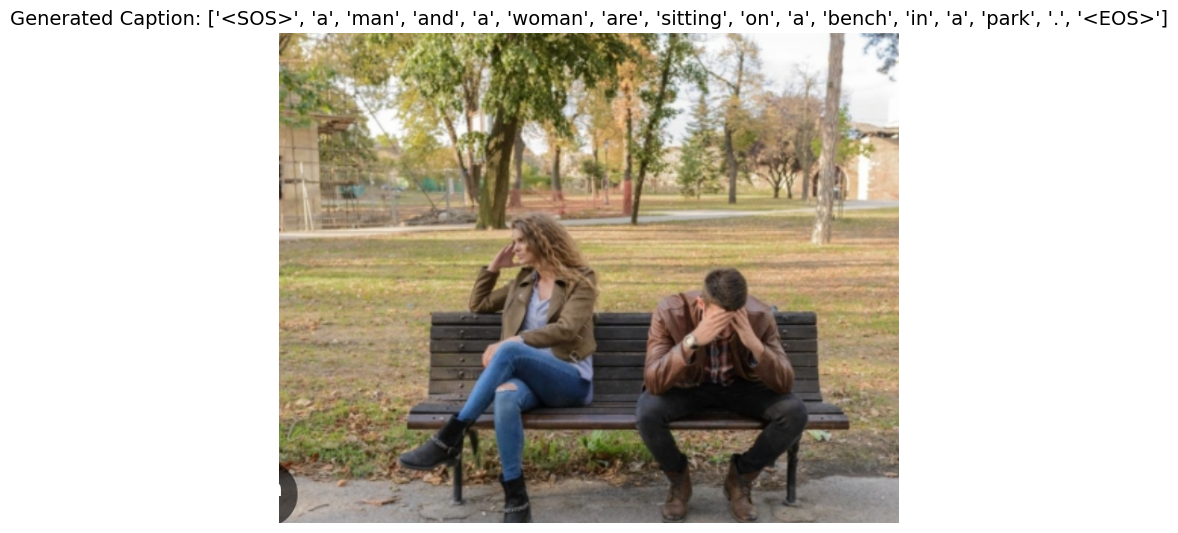

In [14]:
# Load and preprocess the image
image_path = "/content/drive/MyDrive/CV_final_project/test_sets/Screenshot 2024-12-06 at 7.06.31 PM.png"  # Path to your input image
img = Image.open(image_path).convert("RGB")
original_image = img.copy()  # Save the original image for display
img = transform(img).unsqueeze(0)  # Add batch dimension
img = img.to(device)

# Perform inference
with torch.no_grad():
    output = model.caption_image(img, dataset.vocab)  # Use the caption generation function from your model

# Decode the output and print the caption
print("Generated Caption:", output)

# Show the uploaded image alongside the generated caption
plt.figure(figsize=(8, 8))
plt.imshow(original_image)  # Display the original image
plt.axis("off")  # Hide the axis
plt.title(f"Generated Caption: {output}", fontsize=14)
plt.show()

Generated Caption: ['<SOS>', 'a', 'man', 'and', 'a', 'woman', 'are', 'sitting', 'on', 'a', 'bench', 'inside', 'a', 'building', '.', '<EOS>']


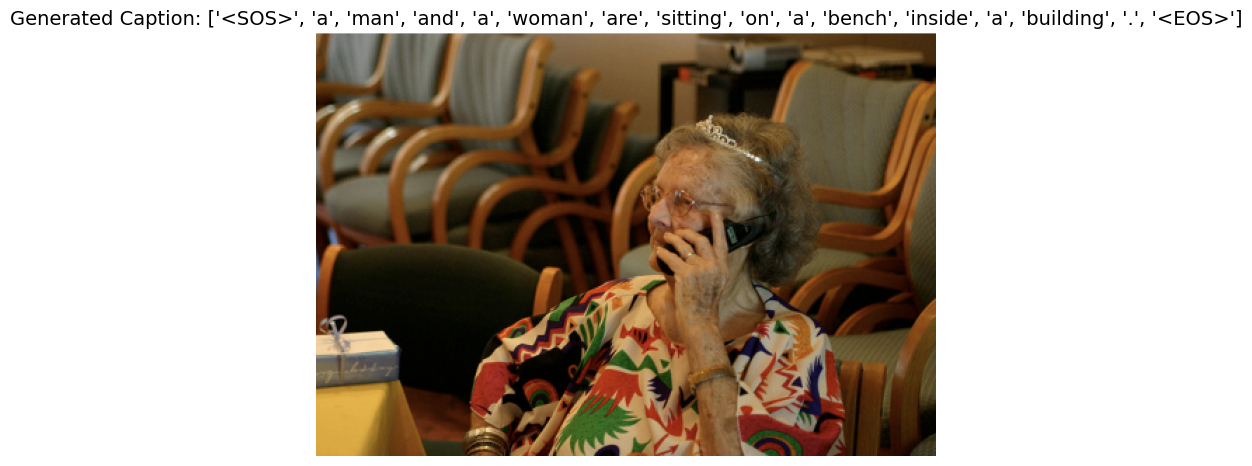

In [15]:
# Load and preprocess the image
image_path = "/content/drive/MyDrive/CV_final_project/test_sets/Screenshot 2024-12-07 at 8.09.16 PM.png"  # Path to your input image
img = Image.open(image_path).convert("RGB")
original_image = img.copy()  # Save the original image for display
img = transform(img).unsqueeze(0)  # Add batch dimension
img = img.to(device)

# Perform inference
with torch.no_grad():
    output = model.caption_image(img, dataset.vocab)  # Use the caption generation function from your model

# Decode the output and print the caption
print("Generated Caption:", output)

# Show the uploaded image alongside the generated caption
plt.figure(figsize=(8, 8))
plt.imshow(original_image)  # Display the original image
plt.axis("off")  # Hide the axis
plt.title(f"Generated Caption: {output}", fontsize=14)
plt.show()

Generated Caption: ['<SOS>', 'a', 'dog', 'runs', 'through', 'the', 'grass', '.', '<EOS>']


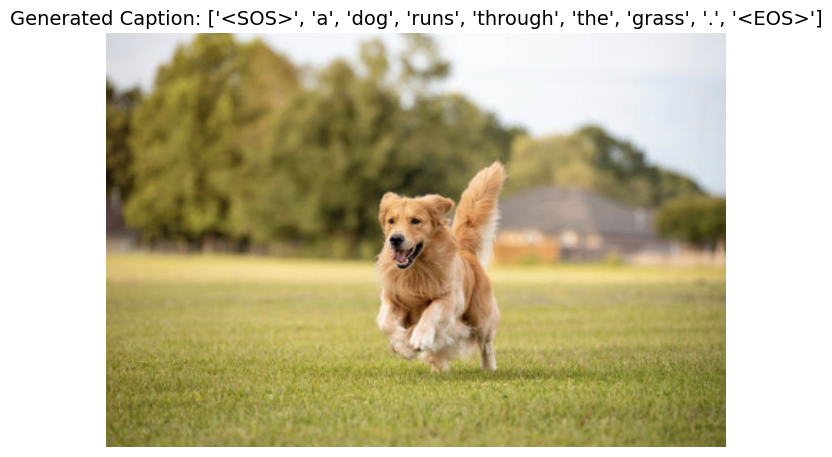

In [16]:
# Load and preprocess the image
image_path = "/content/drive/MyDrive/CV_final_project/test_sets/Screenshot 2024-12-07 at 8.11.25 PM.png"  # Path to your input image
img = Image.open(image_path).convert("RGB")
original_image = img.copy()  # Save the original image for display
img = transform(img).unsqueeze(0)  # Add batch dimension
img = img.to(device)

# Perform inference
with torch.no_grad():
    output = model.caption_image(img, dataset.vocab)  # Use the caption generation function from your model

# Decode the output and print the caption
print("Generated Caption:", output)

# Show the uploaded image alongside the generated caption
plt.figure(figsize=(8, 8))
plt.imshow(original_image)  # Display the original image
plt.axis("off")  # Hide the axis
plt.title(f"Generated Caption: {output}", fontsize=14)
plt.show()

Generated Caption: ['<SOS>', 'a', 'woman', 'in', 'a', 'cowboy', 'hat', 'and', 'a', 'pink', 'shirt', 'is', 'ridding', 'a', 'horse', 'in', 'a', 'competition', '.', '<EOS>']


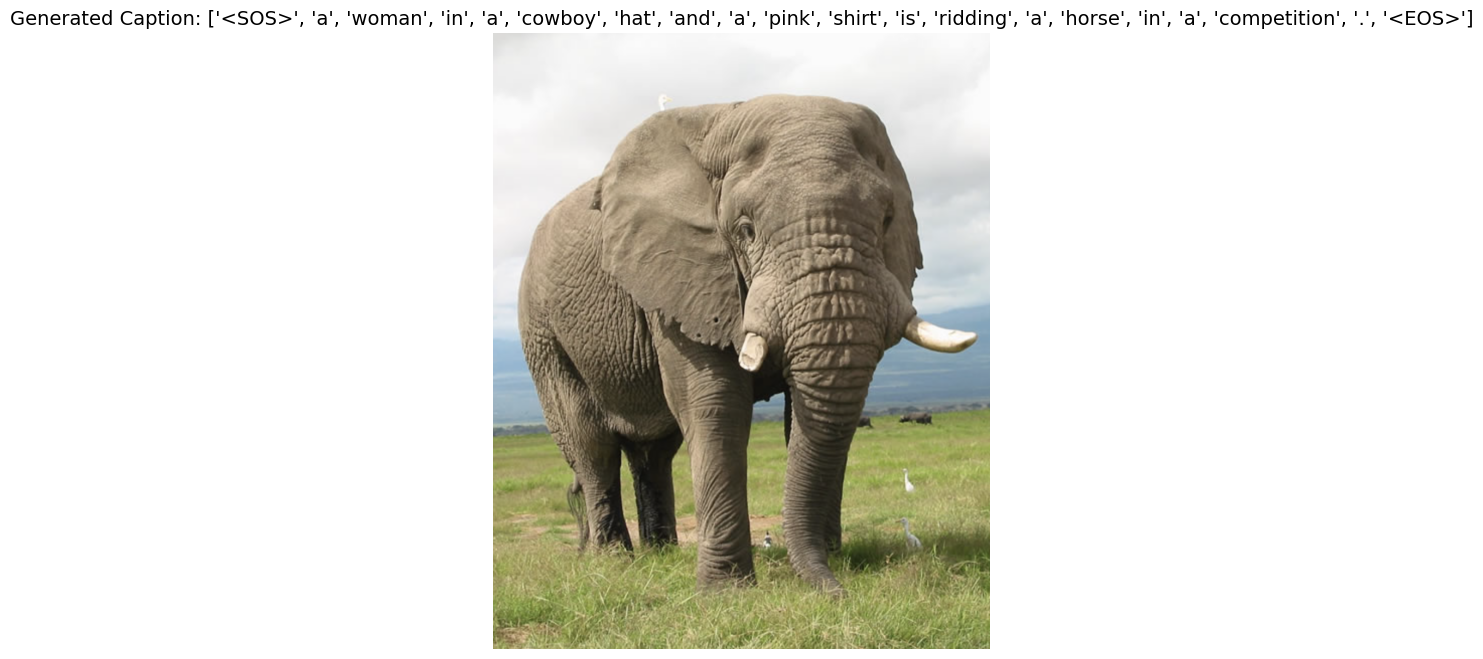

In [17]:
# Load and preprocess the image
image_path = "/content/drive/MyDrive/CV_final_project/test_sets/elephant.png"  # Path to your input image
img = Image.open(image_path).convert("RGB")
original_image = img.copy()  # Save the original image for display
img = transform(img).unsqueeze(0)  # Add batch dimension
img = img.to(device)

# Perform inference
with torch.no_grad():
    output = model.caption_image(img, dataset.vocab)  # Use the caption generation function from your model

# Decode the output and print the caption
print("Generated Caption:", output)

# Show the uploaded image alongside the generated caption
plt.figure(figsize=(8, 8))
plt.imshow(original_image)  # Display the original image
plt.axis("off")  # Hide the axis
plt.title(f"Generated Caption: {output}", fontsize=14)
plt.show()